# Bar 9h15 & k-means cluster & Today Low vs Yesterday Low - Analytics

### Import Library

In [28]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns
import math

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.constrained_layout.use'] = True
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [29]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [30]:
data = dataset.copy()

In [31]:
def bar9h15(tick):
    tick=tick[(tick.index.hour == 9) & (tick.index.minute == 15)]
    if len(tick):
        return tick[0]

In [32]:
data['Close_9h15'] = data['Close']
day_data = data.resample('D').agg({
        'Open': 'first',
        'Close': 'last',
        'High': 'max',
        'Low': 'min',
        'Close_9h15': bar9h15
    })
day_data.dropna(subset=['Close'], inplace=True)

In [33]:
day_data['rate_x'] = 100 * (day_data['Close_9h15'] - day_data['Close'].shift(1)) /  day_data['Close'].shift(1)
day_data['rate_y'] = (day_data['Close_9h15'] - day_data['Open']) / (day_data['High'].shift(1) - day_data['Low'].shift(1))

In [34]:
day_data['diff_low'] = day_data['Low'] - day_data['Low'].shift(1)
day_data['low_is_lower']  = day_data.apply(lambda r: 'Yes' if r['diff_low'] < 0 else "No", axis=1)

In [35]:
day_data

,Open,Close,High,Low,Close_9h15,rate_x,rate_y,diff_low,low_is_lower
Date,,,,,,,,,
2018-08-13,943.5,954.2,954.6,942.3,942.6,NaN,NaN,NaN,No
2018-08-14,955.5,959.3,961.8,952.1,956.9,0.282960,0.113821,9.8,No
2018-08-15,958.0,946.6,962.3,946.6,960.7,0.145940,0.278351,-5.5,Yes
2018-08-16,942.4,947.0,947.3,935.5,942.1,-0.475386,-0.019108,-11.1,Yes
2018-08-17,952.2,947.0,954.6,945.0,953.2,0.654699,0.084746,9.5,No
...,...,...,...,...,...,...,...,...,...
2024-10-31,1339.0,1343.5,1347.8,1333.7,1338.9,-0.230999,-0.008929,2.2,No
2024-11-01,1340.4,1330.4,1340.4,1326.6,1337.7,-0.431708,-0.191489,-7.1,Yes
2024-11-04,1332.8,1318.5,1332.8,1317.1,1328.9,-0.112748,-0.282609,-9.5,Yes


In [36]:
day_data['rate_x'].describe()

count    1553.000000
mean        0.049750
std         0.747471
min        -8.680556
25%        -0.172811
50%         0.077571
75%         0.362403
max         4.561003
Name: rate_x, dtype: float64

In [37]:
day_data['rate_y'].describe()

count    1553.000000
mean        0.007705
std         0.216909
min        -4.216216
25%        -0.090000
50%         0.018519
75%         0.110429
max         1.343284
Name: rate_y, dtype: float64

In [38]:
day_data.dropna(inplace=True)

### Kmeans Clustering

In [39]:
from sklearn.cluster import KMeans

In [40]:
cluster_cols = ["rate_x", "rate_y"]
model = KMeans(n_clusters=24, init='k-means++', random_state=43)
_result = model.fit_predict(day_data[cluster_cols])
day_data = day_data.assign(cluster=_result)

In [42]:
day_data['cluster'].unique()

array([16, 19,  4, 12,  0, 13, 23, 20,  5,  6, 22, 11, 14,  2,  7, 21, 17,
       18,  1, 10,  3,  8, 15,  9], dtype=int32)

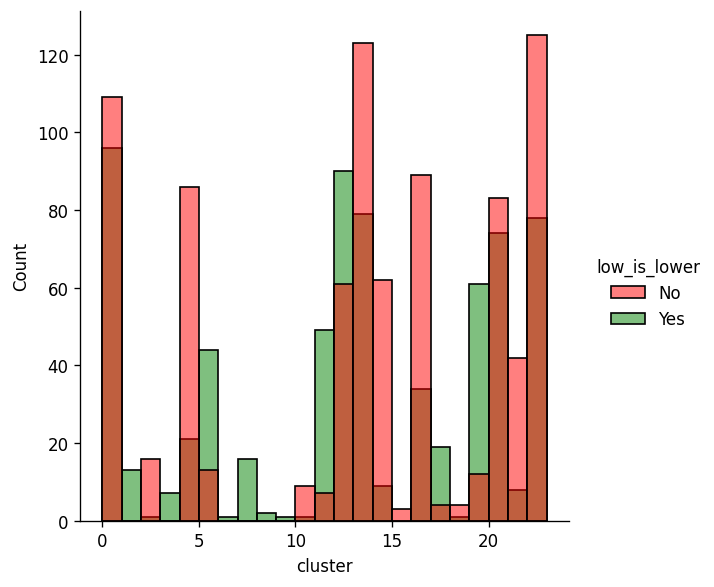

In [44]:
sns.displot(day_data, x="cluster", hue="low_is_lower", palette=dict(Yes="green", No="red"), bins=range(0, 24, 1))

In [46]:
len(day_data[day_data.cluster == 1])

13